In [3]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 22 17:25:13 2016

@author: tabacof
"""

# Implements a variational autoencoder as described in Kingma et al. 2013
# "Auto-Encoding Variational Bayes"
import theano
theano.config.floatX = 'float32'
import theano.tensor as T
import numpy as np
import lasagne
from parmesan.distributions import log_normal2, kl_normal2_stdnormal
from parmesan.layers import SimpleSampleLayer
import time, shutil, os
import scipy
from scipy.io import loadmat
import matplotlib
import pylab as plt
from read_write_model import read_model, write_model
import os
import urllib
import Image

In [4]:
#settings
do_train_model = False
batch_size = 100
latent_size = 100
analytic_kl_term = True
lr = 0.0002
num_epochs = 25
model_filename = "svhn_conv_vae"
nplots = 15
do_generate_png = True

results_out = "results/SVHN_adv_vae"

if not os.path.exists(results_out):
    os.makedirs(results_out)

np.random.seed(1234) # reproducibility

In [5]:
#SYMBOLIC VARS
sym_x = T.tensor4()
sym_lr = T.scalar('lr')

### LOAD DATA
print "Using SVHN dataset"

train_file = 'train_32x32.mat'
test_file = 'test_32x32.mat'

if not os.path.isfile(train_file):
    urllib.urlretrieve('http://ufldl.stanford.edu/housenumbers/train_32x32.mat', train_file)
	
if not os.path.isfile(test_file):
    urllib.urlretrieve('http://ufldl.stanford.edu/housenumbers/test_32x32.mat', test_file)

svhn_train = loadmat(train_file)
svhn_test = loadmat(test_file)

train_x = np.rollaxis(svhn_train['X'], 3).transpose(0,3,1,2).astype(theano.config.floatX)
test_x = np.rollaxis(svhn_test['X'], 3).transpose(0,3,1,2).astype(theano.config.floatX)

svhn_mean = 115.11177966923525
svhn_std = 50.819267906232888
train_x = (train_x - svhn_mean)/svhn_std
test_x = (test_x - svhn_mean)/svhn_std

n_train_batches = train_x.shape[0] / batch_size
n_test_batches = test_x.shape[0] / batch_size

#setup shared variables
sh_x_train = theano.shared(train_x, borrow=True)
sh_x_test = theano.shared(test_x, borrow=True)

Using SVHN dataset


In [6]:
### RECOGNITION MODEL q(z|x)
l_in = lasagne.layers.InputLayer((batch_size, 3, 32, 32))
l_noise = lasagne.layers.BiasLayer(l_in, b = np.zeros((3,32,32), dtype = np.float32), shared_axes = 0, name = "NOISE")
l_noise.params[l_noise.b].remove("trainable")
l_enc_h1 = lasagne.layers.Conv2DLayer(l_noise, num_filters = 32, filter_size = 4, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'ENC_CONV1')
l_enc_h1 = lasagne.layers.Conv2DLayer(l_enc_h1, num_filters = 64, filter_size = 4, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'ENC_CONV2')
l_enc_h1 = lasagne.layers.Conv2DLayer(l_enc_h1, num_filters = 128, filter_size = 4, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'ENC_CONV3')
l_enc_h1 = lasagne.layers.DenseLayer(l_enc_h1, num_units=512, nonlinearity=lasagne.nonlinearities.elu, name='ENC_DENSE2')

l_mu = lasagne.layers.DenseLayer(l_enc_h1, num_units=latent_size, nonlinearity=lasagne.nonlinearities.identity, name='ENC_Z_MU')
l_log_var = lasagne.layers.DenseLayer(l_enc_h1, num_units=latent_size, nonlinearity=lasagne.nonlinearities.identity, name='ENC_Z_LOG_VAR')

#sample the latent variables using mu(x) and log(sigma^2(x))
l_z = SimpleSampleLayer(mean=l_mu, log_var=l_log_var)

In [7]:
### GENERATIVE MODEL p(x|z)
l_dec_h1 = lasagne.layers.DenseLayer(l_z, num_units=512, nonlinearity=lasagne.nonlinearities.elu, name='DEC_DENSE1')
l_dec_h1 = lasagne.layers.ReshapeLayer(l_dec_h1, (batch_size, -1, 4, 4))
l_dec_h1 = lasagne.layers.TransposedConv2DLayer(l_dec_h1, num_filters = 128, crop="same",filter_size = 5, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'DEC_CONV1')
l_dec_h1 = lasagne.layers.TransposedConv2DLayer(l_dec_h1, num_filters = 64, crop="same",filter_size = 5, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'DEC_CONV2')
l_dec_h1 = lasagne.layers.TransposedConv2DLayer(l_dec_h1, num_filters = 32, filter_size = 5, stride = 2, nonlinearity = lasagne.nonlinearities.elu, name = 'DEC_CONV3')
l_dec_x_mu = lasagne.layers.TransposedConv2DLayer(l_dec_h1, num_filters = 3,filter_size = 4, nonlinearity = lasagne.nonlinearities.identity, name = 'DEC_MU')
l_dec_x_mu = lasagne.layers.ReshapeLayer(l_dec_x_mu, (batch_size, -1))
l_dec_x_log_var = lasagne.layers.TransposedConv2DLayer(l_dec_h1, num_filters = 3,filter_size = 4, nonlinearity = lasagne.nonlinearities.identity, name = 'DEC_LOG_VAR')
l_dec_x_log_var = lasagne.layers.ReshapeLayer(l_dec_x_log_var, (batch_size, -1))

# Get outputs from model
# with noise
z_train, z_mu_train, z_log_var_train, x_mu_train, x_log_var_train = lasagne.layers.get_output(
    [l_z, l_mu, l_log_var, l_dec_x_mu, l_dec_x_log_var], sym_x, deterministic=False
)

# without noise
z_eval, z_mu_eval, z_log_var_eval, x_mu_eval, x_log_var_eval = lasagne.layers.get_output(
    [l_z, l_mu, l_log_var, l_dec_x_mu, l_dec_x_log_var], sym_x, deterministic=True
)

In [8]:
#Calculate the loglikelihood(x) = E_q[ log p(x|z) + log p(z) - log q(z|x)]
def ELBO(z, z_mu, z_log_var, x_mu, x_log_var, x):
    """
    Latent z       : gaussian with standard normal prior
    decoder output : bernoulli

    When the output is bernoulli then the output from the decoder
    should be sigmoid. The sizes of the inputs are
    z: (batch_size, num_latent)
    z_mu: (batch_size, num_latent)
    z_log_var: (batch_size, num_latent)
    x_mu: (batch_size, num_features)
    x: (batch_size, num_features)
    """
    kl_term = kl_normal2_stdnormal(z_mu, z_log_var).sum(axis=1)
    log_px_given_z = log_normal2(x.reshape((batch_size, -1)), x_mu, x_log_var).sum(axis=1)
    LL = T.mean(-kl_term + log_px_given_z)

    return LL

# TRAINING LogLikelihood
LL_train = ELBO(z_train, z_mu_train, z_log_var_train, x_mu_train, x_log_var_train, sym_x)

# EVAL LogLikelihood
LL_eval = ELBO(z_eval, z_mu_eval, z_log_var_eval, x_mu_eval, x_log_var_eval, sym_x)


params = lasagne.layers.get_all_params([l_dec_x_mu, l_dec_x_log_var], trainable=True)
for p in params:
    print p, p.get_value().shape

### Take gradient of Negative LogLikelihood
grads = T.grad(-LL_train, params)

# Add gradclipping to reduce the effects of exploding gradients.
# This speeds up convergence
clip_grad = 1
max_norm = 5
mgrads = lasagne.updates.total_norm_constraint(grads,max_norm=max_norm)
cgrads = [T.clip(g,-clip_grad, clip_grad) for g in mgrads]

ENC_CONV1.W (32, 3, 4, 4)
ENC_CONV1.b (32,)
ENC_CONV2.W (64, 32, 4, 4)
ENC_CONV2.b (64,)
ENC_CONV3.W (128, 64, 4, 4)
ENC_CONV3.b (128,)
ENC_DENSE2.W (512, 512)
ENC_DENSE2.b (512,)
ENC_Z_MU.W (512, 100)
ENC_Z_MU.b (100,)
ENC_Z_LOG_VAR.W (512, 100)
ENC_Z_LOG_VAR.b (100,)
DEC_DENSE1.W (100, 512)
DEC_DENSE1.b (512,)
DEC_CONV1.W (32, 128, 5, 5)
DEC_CONV1.b (128,)
DEC_CONV2.W (128, 64, 5, 5)
DEC_CONV2.b (64,)
DEC_CONV3.W (64, 32, 5, 5)
DEC_CONV3.b (32,)
DEC_MU.W (32, 3, 4, 4)
DEC_MU.b (3,)
DEC_LOG_VAR.W (32, 3, 4, 4)
DEC_LOG_VAR.b (3,)


In [9]:
#Setup the theano functions
sym_batch_index = T.iscalar('index')
batch_slice = slice(sym_batch_index * batch_size, (sym_batch_index + 1) * batch_size)

updates = lasagne.updates.adam(cgrads, params, learning_rate=sym_lr)

train_model = theano.function([sym_batch_index, sym_lr], LL_train, updates=updates,
                                  givens={sym_x: sh_x_train[batch_slice]},)

test_model = theano.function([sym_batch_index], LL_eval,
                                  givens={sym_x: sh_x_test[batch_slice]},)

plot_results = theano.function([sym_batch_index], x_mu_eval,
                                  givens={sym_x: sh_x_test[batch_slice]},)

def train_epoch(lr):
    costs = []
    for i in range(n_train_batches):
        cost_batch = train_model(i, lr)
        costs += [cost_batch]
    return np.mean(costs)


def test_epoch():
    costs = []
    for i in range(n_test_batches):
        cost_batch = test_model(i)
        costs += [cost_batch]
    return np.mean(costs)

In [10]:
if do_train_model:
    # Training Loop
    for epoch in range(num_epochs):
        start = time.time()

        #shuffle train data, train model and test model
        np.random.shuffle(train_x)
        sh_x_train.set_value(train_x)
        
        results = plot_results(0)
        plt.figure(figsize=(2, nplots))
        for i in range(0,nplots):
            plt.subplot(nplots,2,(i+1)*2-1)
            plt.imshow((svhn_std*test_x[i].transpose(1,2,0)+svhn_mean)/255.0)
            plt.axis('off')
            plt.subplot(nplots,2,(i+1)*2)
            plt.imshow((svhn_std*results[i].reshape(3,32,32).transpose(1,2,0)+svhn_mean)/255.0)
            plt.axis('off')
        plt.savefig(results_out+"/epoch_"+str(epoch)+".pdf", bbox_inches='tight')
            
        train_cost = train_epoch(lr)
        test_cost = test_epoch()

        t = time.time() - start

        line =  "*Epoch: %i\tTime: %0.2f\tLR: %0.5f\tLL Train: %0.3f\tLL test: %0.3f\t" % ( epoch, t, lr, train_cost, test_cost)
        print line
        with open(logfile,'a') as f:
            f.write(line + "\n")
    
    print "Write model data"
    write_model([l_dec_x_mu, l_dec_x_log_var], model_filename)
else:
    read_model([l_dec_x_mu, l_dec_x_log_var], model_filename)
    

In [11]:
def show_svhn(img, i, title="", save_filename=""): # expects flattened image of shape (3072,) 
    img = img.copy().reshape(3,32,32).transpose(1,2,0)
    img *= svhn_std
    img += svhn_mean
    img /= 255.0
    img = np.clip(img, 0, 1)
    if do_generate_png and save_filename:
        Image.fromarray(np.uint8(img*255), "RGB").save(save_filename, "PNG")
    plt.subplot(3, 2, i)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    
def svhn_input(img):
    return np.tile(img, (batch_size, 1, 1, 1)).reshape(batch_size, 3, 32, 32)

def svhn_dist(img1, img2):
    img1_pixels = img1.flatten()*svhn_std + svhn_mean
    img2_pixels = img2.flatten()*svhn_std + svhn_mean
    return np.linalg.norm(img1_pixels - img2_pixels)

In [12]:
def kld(mean1, log_var1, mean2, log_var2):
    mean_term = (T.exp(0.5*log_var1) + (mean1-mean2)**2.0)/T.exp(0.5*log_var2)
    return mean_term + log_var2 - log_var1 - 0.5

# Autoencoder outputs
mean, log_var, reconstruction = lasagne.layers.get_output(
    [l_mu, l_log_var, l_dec_x_mu], inputs = sym_x, deterministic=True)
    
# Adversarial confusion cost function
    
# Mean squared reconstruction difference
# KL divergence between latent variables
adv_mean =  T.vector()
adv_log_var = T.vector()
adv_confusion = kld(mean, log_var, adv_mean, adv_log_var).sum()

# Adversarial regularization
C = T.scalar()
adv_reg = C*lasagne.regularization.l2(l_noise.b)
# Total adversarial loss
adv_loss = adv_confusion + adv_reg
adv_grad = T.grad(adv_loss, l_noise.b)

# Function used to optimize the adversarial noise
adv_function = theano.function([sym_x, adv_mean, adv_log_var, C], [adv_loss, adv_grad])

# Helper to plot reconstructions    
adv_plot = theano.function([sym_x], reconstruction)

# Function to get latent variables of the target
adv_mean_log_var = theano.function([sym_x], [mean, log_var])

In [13]:
def adv_test(orig_img, target_img, C, plot = True):
    # Set the adversarial noise to zero
    l_noise.b.set_value(np.zeros((3,32,32)).astype(np.float32))
    
    # Get latent variables of the target
    adv_mean_values, adv_log_var_values = adv_mean_log_var(svhn_input(test_x[target_img]))
    adv_mean_values = adv_mean_values[0]
    adv_log_var_values = adv_log_var_values[0]

    original_reconstruction = adv_plot(svhn_input(test_x[orig_img]))[0]
    target_reconstruction = adv_plot(svhn_input(test_x[target_img]))[0]

    orig_reconstruction_dist = svhn_dist(original_reconstruction, test_x[orig_img])
    target_reconstruction_dist = svhn_dist(target_reconstruction, test_x[target_img])
    
    # Plot original reconstruction    
    if plot:
        plt.figure(figsize=(10,10))
        show_svhn(test_x[orig_img], 1, "Original image")
        show_svhn(original_reconstruction, 2, "Original reconstruction")
        
    

    # Initialize the adversarial noise for the optimization procedure
    l_noise.b.set_value(np.random.uniform(-1e-8, 1e-8, size=(3,32,32)).astype(np.float32))
    
    # Optimization function for L-BFGS-B
    def fmin_func(x):
        l_noise.b.set_value(x.reshape(3, 32, 32).astype(np.float32))
        f, g = adv_function(svhn_input(test_x[orig_img]), adv_mean_values, adv_log_var_values, C)
        return float(f), g.flatten().astype(np.float64)
        
    # Noise bounds (pixels cannot exceed 0-1)
    bounds = zip(-svhn_mean/svhn_std-test_x[orig_img].flatten(), (255.0-svhn_mean)/svhn_std-test_x[orig_img].flatten())
    
    # L-BFGS-B optimization to find adversarial noise
    x, f, d = scipy.optimize.fmin_l_bfgs_b(fmin_func, l_noise.b.get_value().flatten(), bounds = bounds, fprime = None, factr = 10, m = 25)
    
    adv_img = adv_plot(svhn_input(test_x[orig_img]))[0]
    
    orig_dist = svhn_dist(adv_img, test_x[orig_img])
    adv_dist = svhn_dist(adv_img, test_x[target_img])
    
    # Plotting results
    if plot:
        show_svhn(x, 3, "Adversarial noise")
        show_svhn(test_x[target_img], 4, "Target image")
        show_svhn((test_x[orig_img].flatten()+x), 5, "Adversarial image", save_filename=results_out+"/svhn_vae_adv_"+str(orig_img)+"_"+str(target_img)+".png")
        show_svhn(adv_img, 6, "Adversarial reconstruction")
    
        plt.show()
        
    plt.close('all')
            
    return orig_dist, adv_dist, orig_reconstruction_dist, target_reconstruction_dist

In [ ]:
def orig_adv_dist(orig_img = None, target_img = None, plot = False):
    if orig_img is None:
        orig_img = np.random.randint(0, len(test_x))
    if target_img is None:
        target_img = np.random.randint(0, len(test_x))
    
    print orig_img, target_img
    
    orig_dist=[]
    adv_dist=[]

    C = np.logspace(-10, 20, 50, base = 2, dtype = np.float32)
    
    for c in C:
        od, ad, ore, tre = adv_test(orig_img, target_img, C=c, plot = False)
        orig_dist.append(od)
        adv_dist.append(ad)

    orig_dist = np.array(orig_dist)
    adv_dist = np.array(adv_dist)
    bestC = C[np.argmax(adv_dist - orig_dist >= 0)-1]

    _, _, orig_reconstruction_dist, target_reconstruction_dist = adv_test(orig_img, target_img, C=bestC, plot = plot)

    if plot:
        #plt.figure()
        #plt.plot(np.log(C), orig_dist, label = "Orig")
        #plt.plot(np.log(C), adv_dist, label = "Adv")
        #plt.ylabel("L2 norm")
        #plt.xlabel("Log regularization weight")
        #plt.legend()
        #plt.plot()

        plt.figure()
        plt.axhline(y=target_reconstruction_dist, linewidth = 2, color = 'cyan', label = "Target reconstruction - Target")
        plt.axvline(x=orig_reconstruction_dist, linewidth = 2, color='DarkOrange', label = "Original reconstruction - Original")
        plt.scatter(adv_dist, orig_dist)
        plt.ylabel("Adversarial reconstruction - Target")
        plt.xlabel("Adversarial - Original")
        plt.legend()
        plt.plot()
        
    y = (orig_dist - target_reconstruction_dist)/orig_dist[0]
    x = (adv_dist - orig_reconstruction_dist)/adv_dist[-1]
    return x, y

19829 8160


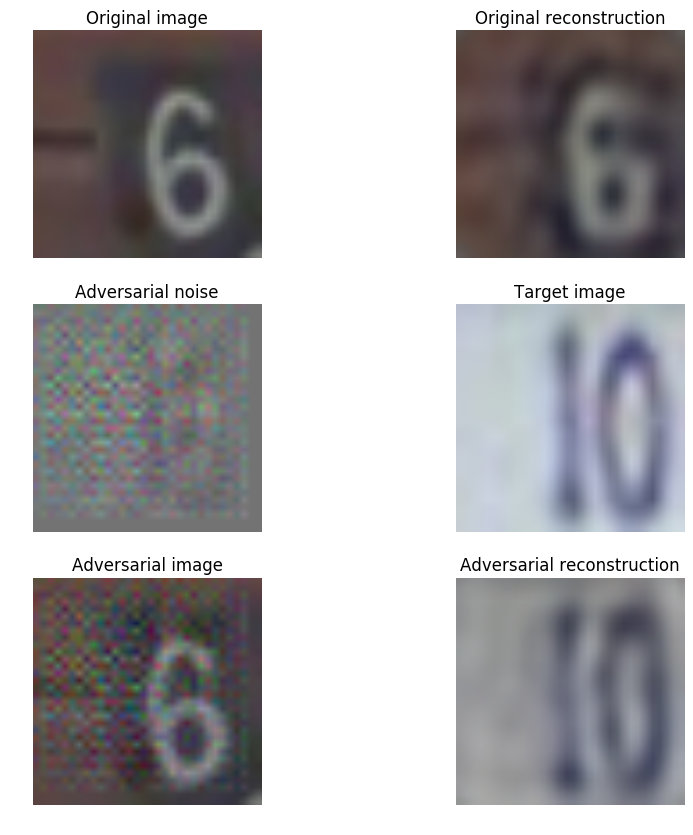

7289 15824


In [ ]:
n = 100

xs = []
ys = []

for i in range(n):
    x, y = orig_adv_dist(plot = True)
    xs.append(x)
    ys.append(y)
    

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(n):
    ax.plot(xs[i], [i]*len(xs[i]), ys[i], color = 'r', alpha = 0.5)

ax.set_xlabel('Adversarial - Original')
ax.set_ylabel('Experiment')
ax.set_zlabel('Adversarial reconstruction - Target')
plt.show()